In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
csv_path = "./CelebA30k.csv"
img_dir = "./CelebA30k"

df = pd.read_csv(csv_path)
df['Male'] = df['Male'].apply(lambda x: 1 if x == 1 else 0)

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Male'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Male'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

batch_size = 128
img_size = (224, 224)
epochs = 10

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_generators():

    for df_ in [train_df, val_df, test_df]:
        df_['Male'] = df_['Male'].astype(str)

    train_gen = train_datagen.flow_from_dataframe(train_df, img_dir, x_col='filename', y_col='Male',
                                                  target_size=img_size, batch_size=batch_size,
                                                  class_mode='binary', shuffle=True)
    val_gen = val_test_datagen.flow_from_dataframe(val_df, img_dir, x_col='filename', y_col='Male',
                                                   target_size=img_size, batch_size=batch_size,
                                                   class_mode='binary', shuffle=False)
    test_gen = val_test_datagen.flow_from_dataframe(test_df, img_dir, x_col='filename', y_col='Male',
                                                    target_size=img_size, batch_size=batch_size,
                                                    class_mode='binary', shuffle=False)

    return train_gen, val_gen, test_gen


Train: 24000, Val: 3000, Test: 3000


In [ ]:
def create_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
    return [early_stopping, reduce_lr]

def build_model(freeze_all=True, learning_rate=0.001):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = not freeze_all
    if not freeze_all:
        for layer in base_model.layers[:-4]:
            layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def run_single_experiment(name, freeze_all, lr):
    print(f"\n{'='*50}\nTraining: {name}\n{'='*50}")
    train_gen, val_gen, test_gen = create_generators()
    model = build_model(freeze_all=freeze_all, learning_rate=lr)
    callbacks = create_callbacks()

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)
    loss, acc = model.evaluate(test_gen)
    print(f"Test accuracy: {acc:.4f}")
    model.save(f"{name}.h5")

    y_pred = model.predict(test_gen)
    y_pred_binary = (y_pred > 0.5).astype(int)
    y_true = test_gen.labels
    cm = confusion_matrix(y_true, y_pred_binary)
    report = classification_report(y_true, y_pred_binary, target_names=['Female', 'Male'])

    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - {name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return {'test_acc': acc, 'history': history.history, 'confusion_matrix': cm}


Training: Freeze_All_LR_0.001
Found 24000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


2025-05-05 02:23:38.113113: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-05 02:23:38.113160: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-05 02:23:38.113167: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-05 02:23:38.113842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 02:23:38.114073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-05-05 02:23:40.087324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 1.7165 - accuracy: 0.8370

2025-05-05 02:34:13.349432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 702s 4s/step - loss: 1.7165 - accuracy: 0.8370 - val_loss: 0.8320 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 675s 4s/step - loss: 1.1735 - accuracy: 0.8562 - val_loss: 0.5818 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 665s 4s/step - loss: 0.4819 - accuracy: 0.8706 - val_loss: 0.2316 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 683s 4s/step - loss: 0.2804 - accuracy: 0.8888 - val_loss: 0.2448 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 686s 4s/step - loss: 0.2668 - accuracy: 0.8936 - val_loss: 0.2210 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 698s 4s/step - loss: 0.2589 - accuracy: 0.8977 - val_loss: 0.2224 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - ETA: 0s - loss: 0.255

/Users/efecankasapoglu/Desktop/hw4/venv310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2025-05-05 03:57:10.034556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 66s 3s/step

Confusion Matrix:
 [[1597  135]
 [ 110 1158]]

Classification Report:
               precision    recall  f1-score   support

      Female       0.94      0.92      0.93      1732
        Male       0.90      0.91      0.90      1268

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



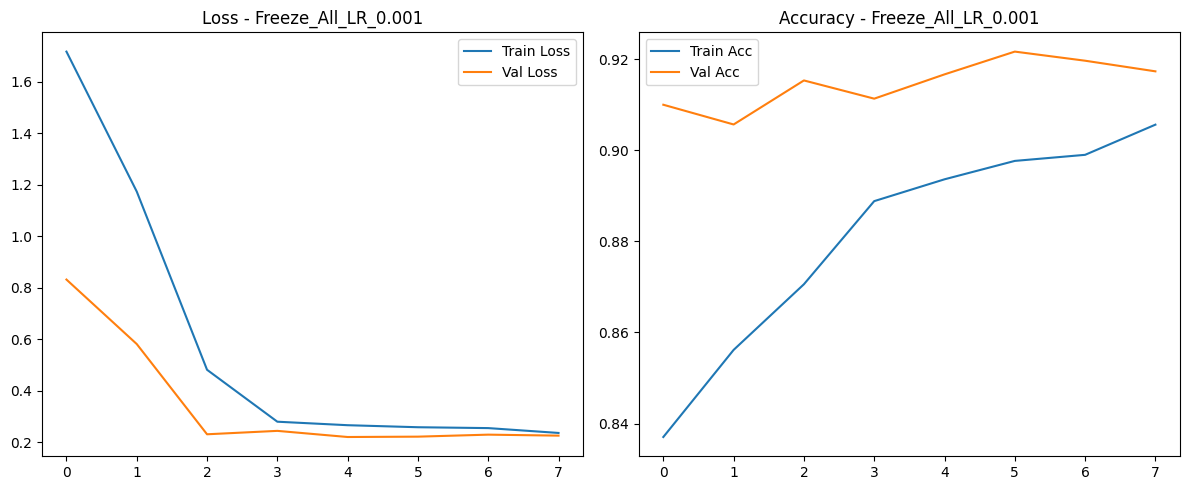

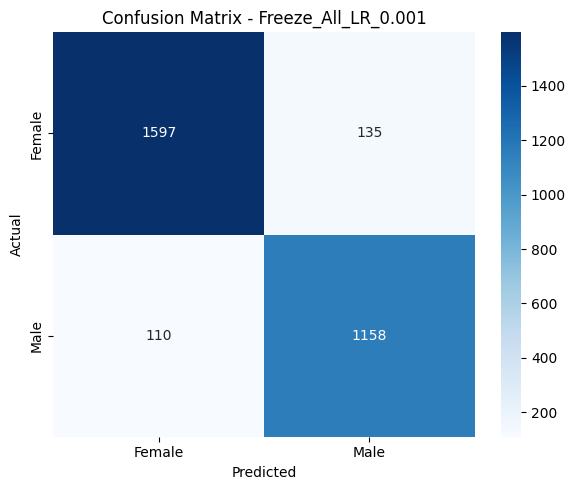

{'test_acc': 0.9183333516120911,
 'history': {'loss': [1.7165172100067139,
   1.173488736152649,
   0.4818620979785919,
   0.28037503361701965,
   0.2667967677116394,
   0.2589258551597595,
   0.2555643320083618,
   0.23675097525119781],
  'accuracy': [0.8370416760444641,
   0.856166660785675,
   0.8705833554267883,
   0.8888333439826965,
   0.893625020980835,
   0.8976666927337646,
   0.8989999890327454,
   0.9056249856948853],
  'val_loss': [0.8319617509841919,
   0.5817533731460571,
   0.23157460987567902,
   0.24481208622455597,
   0.22099711000919342,
   0.22236661612987518,
   0.23015375435352325,
   0.2263278216123581],
  'val_accuracy': [0.9100000262260437,
   0.9056666493415833,
   0.9153333306312561,
   0.9113333225250244,
   0.9166666865348816,
   0.92166668176651,
   0.9196666479110718,
   0.9173333048820496],
  'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00020000001]},
 'confusion_matrix': array([[1597,  135],
        [ 110, 1158]])}

In [ ]:
run_single_experiment("Freeze_All_LR_0.001", freeze_all=True, lr=0.001)


Training: Freeze_All_LR_0.0001
Found 24000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


Epoch 1/10


2025-05-05 03:58:19.551500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 1.5633 - accuracy: 0.7713

2025-05-05 04:08:36.285493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 692s 4s/step - loss: 1.5633 - accuracy: 0.7713 - val_loss: 0.5647 - val_accuracy: 0.9050 - lr: 1.0000e-04
Epoch 2/10
188/188 [==============================] - 701s 4s/step - loss: 1.1536 - accuracy: 0.8338 - val_loss: 0.6120 - val_accuracy: 0.9057 - lr: 1.0000e-04
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 1.0688 - accuracy: 0.8451
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
188/188 [==============================] - 688s 4s/step - loss: 1.0688 - accuracy: 0.8451 - val_loss: 0.6135 - val_accuracy: 0.9103 - lr: 1.0000e-04
Epoch 4/10
188/188 [==============================] - 692s 4s/step - loss: 1.0814 - accuracy: 0.8478 - val_loss: 0.5780 - val_accuracy: 0.9110 - lr: 2.0000e-05
Epoch 4: early stopping
24/24 [==============================] - 75s 3s/step - loss: 0.5342 - accuracy: 0.9090
Test accuracy: 0.9090


/Users/efecankasapoglu/Desktop/hw4/venv310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2025-05-05 04:45:48.433246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 63s 3s/step

Confusion Matrix:
 [[1572  160]
 [ 113 1155]]

Classification Report:
               precision    recall  f1-score   support

      Female       0.93      0.91      0.92      1732
        Male       0.88      0.91      0.89      1268

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



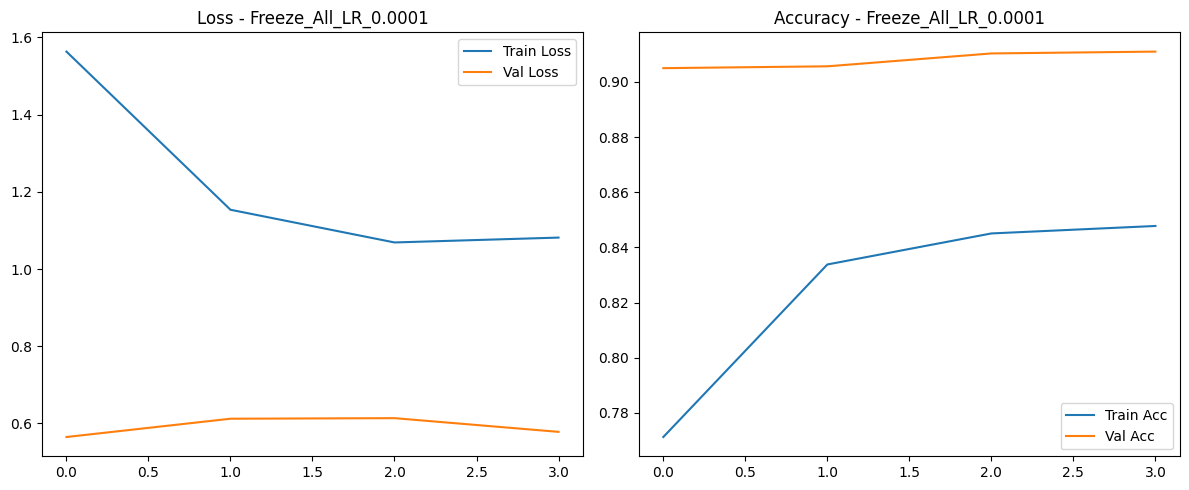

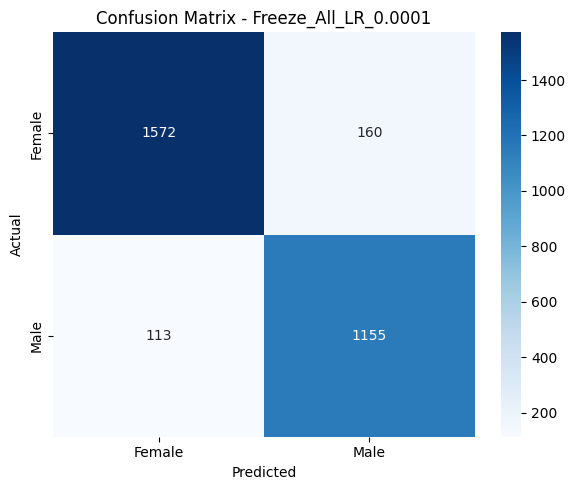

{'test_acc': 0.9089999794960022,
 'history': {'loss': [1.5633492469787598,
   1.1535550355911255,
   1.0687940120697021,
   1.0813984870910645],
  'accuracy': [0.7712916731834412,
   0.8338333368301392,
   0.8450833559036255,
   0.8477916717529297],
  'val_loss': [0.5646509528160095,
   0.6120454668998718,
   0.6134926080703735,
   0.5780093669891357],
  'val_accuracy': [0.9049999713897705,
   0.9056666493415833,
   0.9103333353996277,
   0.9110000133514404],
  'lr': [1e-04, 1e-04, 1e-04, 2e-05]},
 'confusion_matrix': array([[1572,  160],
        [ 113, 1155]])}

In [ ]:
run_single_experiment("Freeze_All_LR_0.0001", freeze_all=True, lr=0.0001)


Training: Fine_Tune_LastBlock_LR_0.001
Found 24000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


Epoch 1/10


2025-05-05 04:46:55.788923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 1.9679 - accuracy: 0.5647

2025-05-05 04:59:33.269490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 833s 4s/step - loss: 1.9679 - accuracy: 0.5647 - val_loss: 0.6812 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 828s 4s/step - loss: 0.6816 - accuracy: 0.5773 - val_loss: 0.6814 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5773
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
188/188 [==============================] - 841s 4s/step - loss: 0.6813 - accuracy: 0.5773 - val_loss: 0.6812 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 833s 4s/step - loss: 0.6813 - accuracy: 0.5773 - val_loss: 0.6811 - val_accuracy: 0.5773 - lr: 2.0000e-04
Epoch 5/10
188/188 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.5773
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
188/188 [==============================] - 823s 

/Users/efecankasapoglu/Desktop/hw4/venv310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2025-05-05 06:25:49.033361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 72s 3s/step


/Users/efecankasapoglu/Desktop/hw4/venv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/efecankasapoglu/Desktop/hw4/venv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/efecankasapoglu/Desktop/hw4/venv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


Confusion Matrix:
 [[1732    0]
 [1268    0]]

Classification Report:
               precision    recall  f1-score   support

      Female       0.58      1.00      0.73      1732
        Male       0.00      0.00      0.00      1268

    accuracy                           0.58      3000
   macro avg       0.29      0.50      0.37      3000
weighted avg       0.33      0.58      0.42      3000



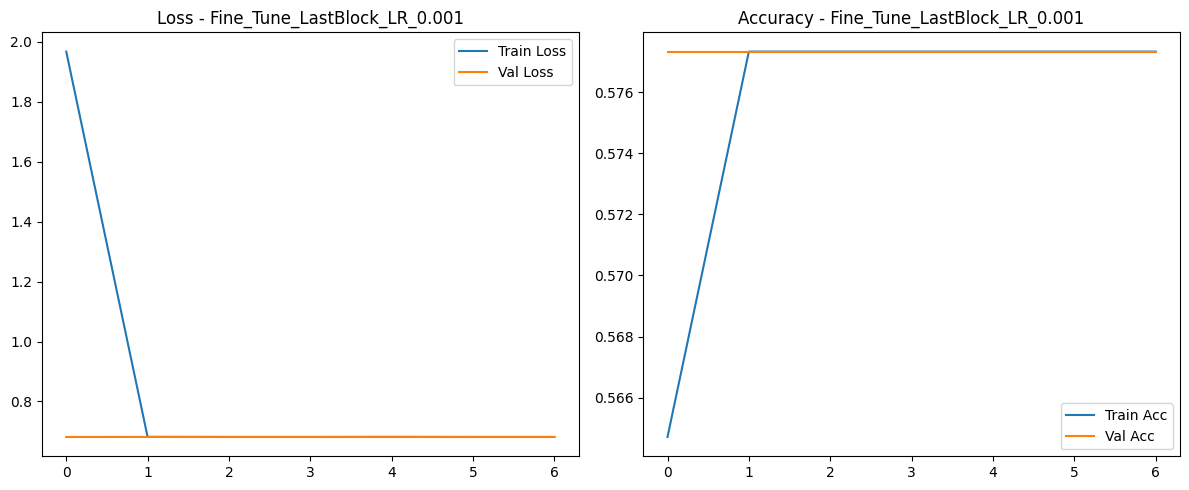

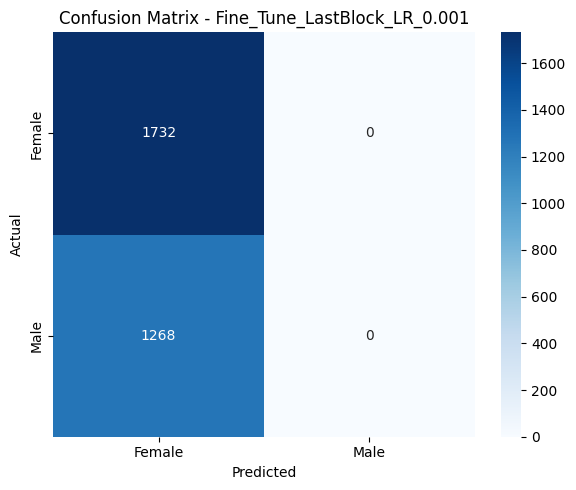

{'test_acc': 0.5773333311080933,
 'history': {'loss': [1.967893123626709,
   0.6815667152404785,
   0.6813077926635742,
   0.681272029876709,
   0.6816492080688477,
   0.681257426738739,
   0.6812963485717773],
  'accuracy': [0.5647083520889282,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933],
  'val_loss': [0.6811676621437073,
   0.6813703775405884,
   0.6811684370040894,
   0.681140124797821,
   0.6811566352844238,
   0.6811491847038269,
   0.6811462640762329],
  'val_accuracy': [0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933,
   0.5773333311080933],
  'lr': [0.001,
   0.001,
   0.001,
   0.00020000001,
   0.00020000001,
   4.0000003e-05,
   4.0000003e-05]},
 'confusion_matrix': array([[1732,    0],
        [1268,    0]])}

In [ ]:
run_single_experiment("Fine_Tune_LastBlock_LR_0.001", freeze_all=False, lr=0.001)


Training: Fine_Tune_LastBlock_LR_0.0001
Found 24000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


Epoch 1/10


2025-05-05 06:27:04.841386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8622

2025-05-05 06:40:19.859175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 873s 5s/step - loss: 0.3829 - accuracy: 0.8622 - val_loss: 0.1536 - val_accuracy: 0.9510 - lr: 1.0000e-04
Epoch 2/10
188/188 [==============================] - 844s 4s/step - loss: 0.1491 - accuracy: 0.9454 - val_loss: 0.1033 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 3/10
188/188 [==============================] - 844s 4s/step - loss: 0.1090 - accuracy: 0.9605 - val_loss: 0.0979 - val_accuracy: 0.9647 - lr: 1.0000e-04
Epoch 4/10
188/188 [==============================] - 832s 4s/step - loss: 0.0994 - accuracy: 0.9648 - val_loss: 0.0947 - val_accuracy: 0.9673 - lr: 1.0000e-04
Epoch 5/10
188/188 [==============================] - 837s 4s/step - loss: 0.0828 - accuracy: 0.9698 - val_loss: 0.0930 - val_accuracy: 0.9717 - lr: 1.0000e-04
Epoch 6/10
188/188 [==============================] - 842s 4s/step - loss: 0.0740 - accuracy: 0.9737 - val_loss: 0.0730 - val_accuracy: 0.9747 - lr: 1.0000e-04
Epoch 7/10
188/188 [==============================]

/Users/efecankasapoglu/Desktop/hw4/venv310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2025-05-05 08:34:30.668992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 69s 3s/step

Confusion Matrix:
 [[1696   36]
 [  32 1236]]

Classification Report:
               precision    recall  f1-score   support

      Female       0.98      0.98      0.98      1732
        Male       0.97      0.97      0.97      1268

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



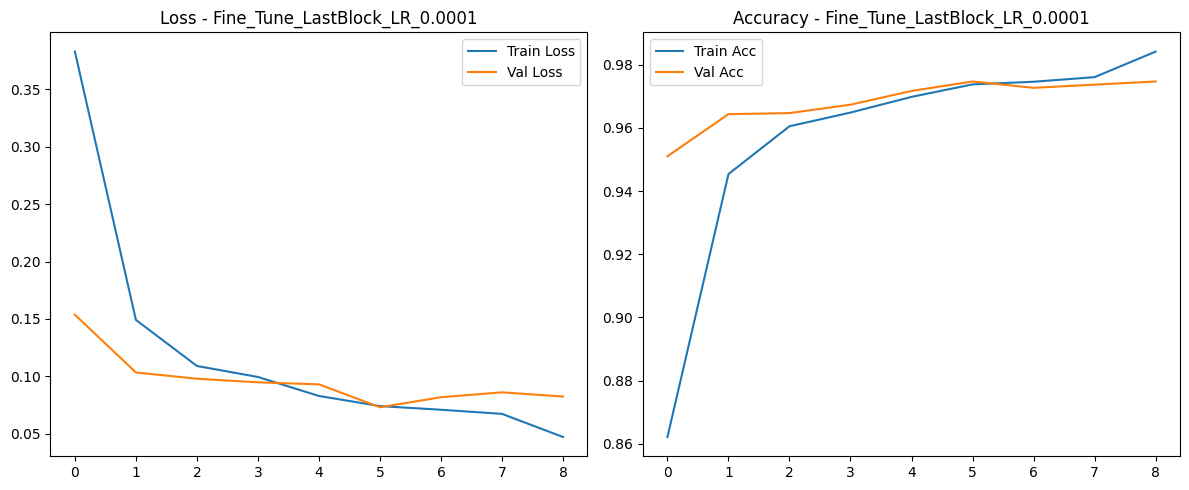

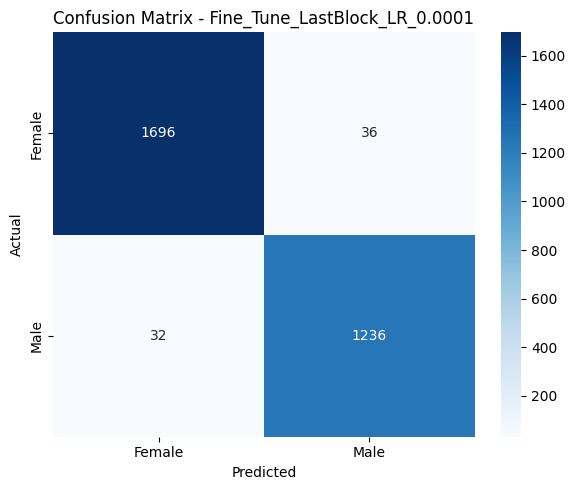

{'test_acc': 0.9773333072662354,
 'history': {'loss': [0.3828900456428528,
   0.14912547171115875,
   0.10898159444332123,
   0.09940869361162186,
   0.08284581452608109,
   0.07403174042701721,
   0.070843406021595,
   0.06725146621465683,
   0.047094739973545074],
  'accuracy': [0.8621666431427002,
   0.9453750252723694,
   0.9605000019073486,
   0.9648333191871643,
   0.9697916507720947,
   0.9737499952316284,
   0.9745833277702332,
   0.9760416746139526,
   0.984125018119812],
  'val_loss': [0.1536257416009903,
   0.10332866758108139,
   0.09787614643573761,
   0.09472779184579849,
   0.09298110753297806,
   0.07300614565610886,
   0.08175595104694366,
   0.08603426069021225,
   0.0823478102684021],
  'val_accuracy': [0.9509999752044678,
   0.9643333554267883,
   0.9646666646003723,
   0.9673333168029785,
   0.971666693687439,
   0.9746666550636292,
   0.9726666808128357,
   0.9736666679382324,
   0.9746666550636292],
  'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04,

In [ ]:
run_single_experiment("Fine_Tune_LastBlock_LR_0.0001", freeze_all=False, lr=0.0001)

Found 24000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


2025-05-05 21:11:14.486651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 87s 4s/step


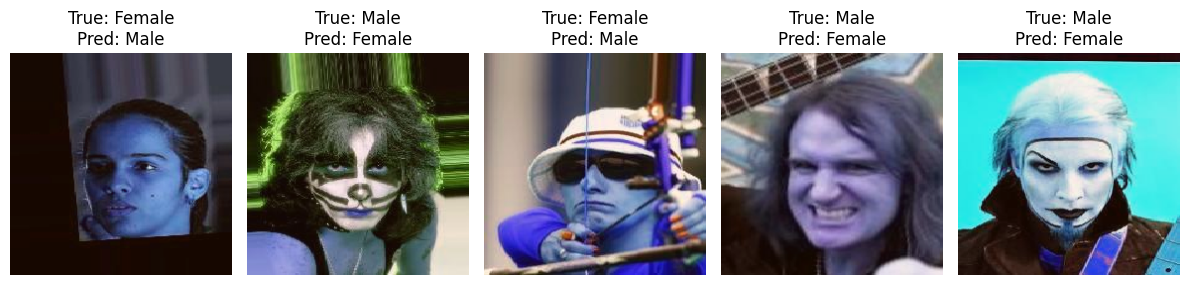

In [ ]:
import random
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.models import load_model

model = load_model("Fine_Tune_LastBlock_LR_0.0001.h5")
_, _, test_gen = create_generators()

test_gen.reset()
all_images = []
all_labels = []

for _ in range(len(test_gen)):
    imgs, labels = next(test_gen)
    all_images.extend(imgs)
    all_labels.extend(labels)
y_pred_probs = model.predict(np.array(all_images), batch_size=128)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.array(all_labels).astype(int)
wrong_indices = [i for i in range(len(y_true)) if y_pred[i] != y_true[i]]
sampled_indices = random.sample(wrong_indices, min(5, len(wrong_indices)))
plt.figure(figsize=(12, 4))
for i, idx in enumerate(sampled_indices):
    image = all_images[idx]
    true_label = "Male" if y_true[idx] == 1 else "Female"
    pred_label = "Male" if y_pred[idx] == 1 else "Female"

    plt.subplot(1, 5, i+1)
    plt.imshow(array_to_img(image))
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()